## NASA Space Apps - Seismic Detection Across the Solar System 
**Group: Kabsa Warriors** <br>

**Description**
<br>
Transferring high-resolution seismic signals back to Earth can be challenging depending on the amount of data and the distance covered. On this notebook, the group utilized Gradient Boosting Classifier to classify uncatalogued data that will help distinguish signals that are summarized and sent back to the receiver on earth. This jupyter notebook contains the installation of different packages, pre-processing the data, as well as using a machine learning algorithm to leverage the existing data and predict the data that are unlabeled. The scope of this notebook revolves around classifying or labeling data regarding lunar seismic test data.<br>

**Objectives**
<li>Leverage existing Machine Learning Models</li>
<li>Use a specific Machine Learning Classifier in order to label uncatalogued data</li>
<li>Apply the best model to training data to lunar data provided by NASA</li> <br>

**Steps**
<li>Install the prerequisites</li>
<li>Read Sample Data and Understand Data</li>
<li>Data Preprocessing - Converting Data to Velocity Values</li>
<li>Execute Data Aggregation</li>
<li>Find the most suitable classification ML for the Data</li>
<li>Select the Selected Machine Learning Classifier</li>
<li>Data Preprocessing from the existing Testing Data</li>
<li>Apply the Machine Learning Classifier on Test Data</li>



### Install the prerequisite packages

In [ ]:
%pip install markupsafe==2.0.1 Jinja2
%pip install pycaret imblearn
%pip install numpy pandas obspy matplotlib scipy

### Read Sample Data and Understand Data

Just like how we used the demo_notebook provided by NASA, we will be explaining the data that we have used in this notebook. Using the commands below will display Lunar data moonquake (mq_type), which is our focus for labeling uncatalogued data from the lunar test data.<br>

But before we proceed in understanding the data, this study focuses on the seismic wave propagation - velocity. Velocity data provides insights into how seismic waves travel through different moon's layers. Different seismic wave types (P-waves, S-waves, surface waves) travel at different velocities, which can indicate the nature of the medium they are passing through. Analyzing the velocity of seismic waves can help distinguish between various seismic events (e.g., shallow vs. deep moonquakes) based on their velocity characteristics. Although, with limited data, we will focus on the catalouged data that is labeled with its velocity characteristics.

In [1]:
# Import the libraries that will be used for this notebook
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

# Retrieve the directory for catalog
cat_directory = './data/lunar/training/catalogs/'
# Find the catalog file and display the file list
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


Let's pick the first seismic event in the catalog and plot the following data for the measurement period. Different files from the catalouged data provide different plot velocity, which can be used to determine patterns of respective moonquake such as impact, shallow, or deep.

Instead of detecting the signals that needs to be read for useful data, the group aims to abstract the process and prioritize on the results of classifying the type of moonquake.

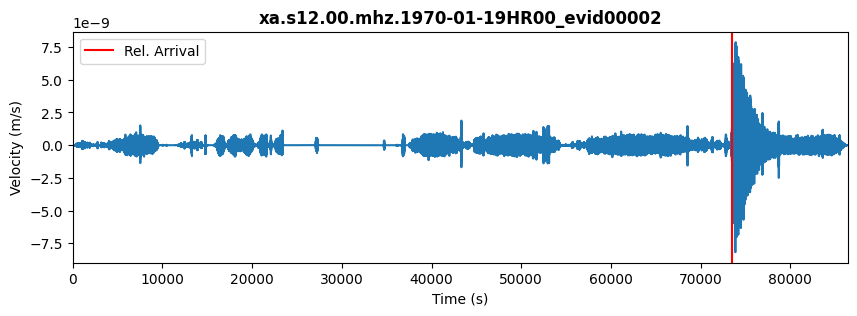

In [2]:
# Select the event id 0002
row = cat.iloc[0]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

# Let's also get the name of the file
test_filename = row.filename
test_filename

# Read the file in csv, but we will use miniseed later
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

### Preprocessing the Data
Now, we can use the velocity for the mesurement period by creating our own preprocessing method below.<br>

First, we have to convert all data from the catalog:<br>
(time/relative_time/velocity) to (Mean Velocity,Std Dev,Min Velocity,Max Velocity,Range,Median,Kurtosis,Skewness,Energy,MQ_type)<br>
By combining the data, one miniseed data will be inserted as one row of data into our new preprocessed file.<br>

*Note: Run the code below if there is no preprocessed data file yet. This will take a long time to pre-process for approx. 8 minutes.*

In [19]:
from scipy.stats import kurtosis, skew

# Test and Read the files from the lunar directory (use the MINISEED files for faster processing)
# Path to the data directory containing the MiniSEED files
catalog_directory = pd.read_csv('data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')
data_directory = './data/lunar/training/data/S12_GradeA/'
temp_directory = ''

for filename, mq_type in zip(catalog_directory['filename'], catalog_directory['mq_type']):
    print(filename, mq_type) 

# Create an empty DataFrame with specified column names
columns = ['Mean Velocity', 'Std Dev', 'Min Velocity', 'Max Velocity', 'Range', 'Median', 'Kurtosis', 'Skewness', 'Energy']
velocity_df = pd.DataFrame(columns=columns)
csv_file_path = 'PreProcessedSeismicData00.csv'

# Find if catalog directory elements can be found in the data directory
# If the data is found, process the data
for file, mq_type in zip(catalog_directory['filename'], catalog_directory['mq_type']):
    mseed_file = f'{data_directory}{file}.mseed'
    print("Mseed_file",mseed_file)
    if os.path.exists(mseed_file):
        print("=============================================================")
        print("[ALERT] WORKING ON NEW FILE")
        print("[SUCCESS] " + file + " exists from the catalog")
        st = read(mseed_file)

        # Get the first trace (modify if there are multiple traces per file)
        trace = st[0]
        # Extract the amplitude values (which represent seismic data)
        amplitude_values = trace.data
        # Get the start time from the trace
        start_time = trace.stats.starttime  # This is an obspy.UTCDateTime object
        # Sampling interval (time between successive samples)
        sampling_interval = trace.stats.delta
        # Generate absolute time for each sample
        time_abs = [start_time + i * sampling_interval for i in range(len(amplitude_values))]
        # Calculate relative time from the start time in seconds
        time_rel = [(t - start_time) for t in time_abs]
        # Calculate velocity (assuming amplitude represents displacement)
        velocity = np.gradient(amplitude_values, sampling_interval)
        # Create a pandas DataFrame with time_abs, time_rel, velocity, and target
        df = pd.DataFrame({
            'time_abs': time_abs,
            'time_rel': time_rel,
            'velocity': velocity
        })

        print("[ALERT]",file, "has been converted to data frame successfully!")
        # Assuming your DataFrame is named df and looks like the provided data
        # Convert time_abs to datetime format if it's a UTCDateTime object
        if isinstance(df['time_abs'].iloc[0], pd.Timestamp):  # If already in Timestamp format
            df['time_abs'] = pd.to_datetime(df['time_abs'])
        else:
            df['time_abs'] = pd.to_datetime(df['time_abs'].apply(lambda x: x.datetime))  # Convert UTCDateTime to datetime

        # Check the date range
        min_date = df['time_abs'].min()
        max_date = df['time_abs'].max()

        # Print the date range
        print(f"Date Range: {min_date} to {max_date}")

        # Calculate the velocity statistics
        mean_velocity = df['velocity'].mean()
        std_velocity = df['velocity'].std()
        min_velocity = df['velocity'].min()
        max_velocity = df['velocity'].max()
        range_velocity = max_velocity - min_velocity
        median_velocity = df['velocity'].median()
        kurtosis_velocity = kurtosis(df['velocity'])
        skewness_velocity = skew(df['velocity'])
        energy_velocity = (df['velocity'] ** 2).sum()

        new_row = pd.DataFrame([{
                    'Mean Velocity':    mean_velocity, 
                    'Std Dev':          std_velocity, 
                    'Min Velocity':     min_velocity, 
                    'Max Velocity':     max_velocity, 
                    'Range':            range_velocity, 
                    'Median':           median_velocity, 
                    'Kurtosis':         kurtosis_velocity, 
                    'Skewness':         skewness_velocity, 
                    'Energy':           energy_velocity,
                    'MQ_type':          mq_type
                }])
        velocity_df = pd.concat([velocity_df, new_row], ignore_index=True)
        print("[SUCCESS]",file, "has been converted to velocity dataframe:")
        velocity_df.to_csv(csv_file_path, index=False)
    else:
        print("[FAILED] " + temp_directory + " does not exist from the catalog")
    print("=============================================================")

xa.s12.00.mhz.1970-01-19HR00_evid00002 impact_mq
xa.s12.00.mhz.1970-03-25HR00_evid00003 impact_mq
xa.s12.00.mhz.1970-03-26HR00_evid00004 impact_mq
xa.s12.00.mhz.1970-04-25HR00_evid00006 impact_mq
xa.s12.00.mhz.1970-04-26HR00_evid00007 deep_mq
xa.s12.00.mhz.1970-06-15HR00_evid00008 impact_mq
xa.s12.00.mhz.1970-06-26HR00_evid00009 impact_mq
xa.s12.00.mhz.1970-07-20HR00_evid00010 impact_mq
xa.s12.00.mhz.1970-07-20HR00_evid00011 deep_mq
xa.s12.00.mhz.1970-09-26HR00_evid00013 impact_mq
xa.s12.00.mhz.1970-10-24HR00_evid00014 impact_mq
xa.s12.00.mhz.1970-11-12HR00_evid00015 impact_mq
xa.s12.00.mhz.1970-12-11HR00_evid00017 impact_mq
xa.s12.00.mhz.1970-12-27HR00_evid00019 deep_mq
xa.s12.00.mhz.1970-12-31HR00_evid00021 deep_mq
xa.s12.00.mhz.1971-01-15HR00_evid00022 impact_mq
xa.s12.00.mhz.1971-01-28HR00_evid00023 deep_mq
xa.s12.00.mhz.1971-01-29HR00_evid00024 impact_mq
xa.s12.00.mhz.1971-02-09HR00_evid00026 impact_mq
xa.s12.00.mhz.1971-03-25HR00_evid00028 impact_mq
xa.s12.00.mhz.1971-04-13HR00_e

Now, let's check for the newly processed data that is combined into one file: PreProcessedSeismicData00.csv

In [7]:
import pandas as pd
# Now let's check for the newly processed data
processed_data = pd.read_csv('PreProcessedSeismicData00.csv')
processed_data.head()

# Change the parameter for MQ_type such as deep_mq/shallow_mq/impact_mq
display_df = processed_data[processed_data['MQ_type'] == 'impact_mq']
display_df

,Mean Velocity,Std Dev,Min Velocity,Max Velocity,Range,Median,Kurtosis,Skewness,Energy,MQ_type
0,2.085638e-20,1.485722e-09,-3.709381e-08,3.905484e-08,7.614865e-08,-7.329450e-18,78.048983,0.015250,1.263529e-12,impact_mq
1,6.347318e-21,1.203664e-09,-2.230630e-08,2.245841e-08,4.476471e-08,-1.643171e-12,16.903036,0.011717,8.293117e-13,impact_mq
2,3.227816e-20,1.265579e-09,-3.231271e-08,3.394645e-08,6.625915e-08,-1.588189e-16,42.556603,0.009271,9.168233e-13,impact_mq
3,-5.419658e-20,1.444317e-09,-3.102977e-08,3.228724e-08,6.331701e-08,-4.669164e-14,52.654258,-0.011643,1.194084e-12,impact_mq
5,4.074241e-21,2.455980e-09,-8.552719e-08,9.361804e-08,1.791452e-07,-2.608044e-16,144.958600,0.042190,3.452727e-12,impact_mq
...,...,...,...,...,...,...,...,...,...,...
70,7.919645e-22,1.191268e-09,-3.344433e-08,3.240093e-08,6.584526e-08,2.489345e-15,89.938154,-0.090466,8.123283e-13,impact_mq
71,-9.728932e-20,9.667664e-09,-3.793859e-07,3.135460e-07,6.929318e-07,-3.458467e-15,212.466894,-0.491203,5.350069e-11,impact_mq
72,1.494858e-21,1.800875e-08,-6.185171e-07,5.397853e-07,1.158302e-06,1.020433e-11,182.815735,-1.329423,1.856435e-10,impact_mq
73,2.322906e-20,1.008474e-09,-4.838543e-08,3.524221e-08,8.362763e-08,-1.716932e-13,109.292769,-0.221613,5.821522e-13,impact_mq


### Use StandardScaler for Data Aggregation

The team decided to use data aggregation in order to balance out the datasets because shallow_mq and deep_mq underrepresent the dataset. Thus, synthetic dataset can be utilized to achieve better results from the machine learning algorithm.

In [41]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the data
df = pd.read_csv('PreProcessedSeismicData00.csv')

# Convert the target (MQ_type) to numeric values using LabelEncoder
label_encoder = LabelEncoder()
df['MQ_type'] = label_encoder.fit_transform(df['MQ_type'])

# Get the mapping of original labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Separate features and target
X = df.drop(columns=['MQ_type'])
y = df['MQ_type']

# Standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separate the classes into different DataFrames
impact_mq_df = df[df['MQ_type'] == label_mapping['impact_mq']]  
shallow_mq_df = df[df['MQ_type'] == label_mapping['shallow_mq']]  
deep_mq_df = df[df['MQ_type'] == label_mapping['deep_mq']]  

# Calculate the desired number of samples for shallow_mq and deep_mq
# You divide this by two by including //2 in order to test different balanced data
# Ex. desired_shallow_count = len(impact_mq_df) // 2
desired_shallow_count = len(impact_mq_df)   
desired_deep_count = len(impact_mq_df) 

# Resample shallow_mq and deep_mq
shallow_mq_resampled = shallow_mq_df.sample(n=desired_shallow_count, replace=True, random_state=42)
deep_mq_resampled = deep_mq_df.sample(n=desired_deep_count, replace=True, random_state=42)

# Combine the original impact_mq_df with the resampled shallow_mq and deep_mq
combined_df = pd.concat([impact_mq_df, shallow_mq_resampled, deep_mq_resampled], ignore_index=True)

# Now you can balance the features again if you want
X_final = combined_df.drop(columns=['MQ_type'])
y_final = combined_df['MQ_type']

# Optionally standardize the feature values again
X_final_scaled = scaler.fit_transform(X_final)

# Export the combined DataFrame to a single CSV file
# Restore original labels because the mq_types were transformed to numerical values
combined_df['MQ_type'] = label_encoder.inverse_transform(combined_df['MQ_type'])  

#=============================================
# The code below saves the balanced .csv file 
# Uncomment the code below if you'd like to create new set of balanced data
# The balanced data can be located in ./balanced_data/ directory
#=============================================
# Make sure to change the .csv filename before executing the code below!
# combined_df.to_csv('./balanced_data/BalancedSeismicData_03.csv', index=False)
# print("\nBalanced dataset has been exported to 'BalancedSeismicData.csv' with original labels.")


Balanced dataset has been exported to 'BalancedSeismicData.csv' with original labels.


## Find the most suitable classification ML for the Data

Finding the most suitable classification Machine Learning Algorithm can be challenging as the dataset varies accross different moonquakes. Especially using the pycaret library, we can feed our data into the machine learning pipeline and determine which algorithms perform in contrast to other algorithms. 

In [9]:
from pycaret.classification import setup, compare_models, evaluate_model, predict_model, save_model, load_model
import pandas as pd

# The balanced seismic data selected is BalancedSeismicData.csv
df = pd.read_csv('./balanced_data/BalancedSeismicData.csv')
s = setup(df, target='MQ_type')

# The code below is commented out because the selected fit Machine learning algorithm is Gradient_Boosting_Machine.pkl
# Uncomment the code below if you'd like to try another model.
best_model=compare_models()

,Description,Value
0,Session id,3720
1,Target,MQ_type
2,Target type,Multiclass
3,Target mapping,"deep_mq: 0, impact_mq: 1, shallow_mq: 2"
4,Original data shape,"(189, 10)"
5,Transformed data shape,"(189, 10)"
6,Transformed train set shape,"(132, 10)"
7,Transformed test set shape,"(57, 10)"
8,Numeric features,9
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9462,0.9831,0.9462,0.9564,0.9429,0.9188,0.9255,0.0340
rf,Random Forest Classifier,0.9159,0.9829,0.9159,0.9302,0.9126,0.8731,0.8825,0.0410
gbc,Gradient Boosting Classifier,0.9088,0.0000,0.9088,0.9303,0.9039,0.8625,0.8752,0.0560
lightgbm,Light Gradient Boosting Machine,0.9077,0.9760,0.9077,0.9238,0.9046,0.8609,0.8712,0.0460
dt,Decision Tree Classifier,0.9011,0.9233,0.9011,0.9254,0.8956,0.8513,0.8658,0.0090
knn,K Neighbors Classifier,0.7643,0.8997,0.7643,0.7890,0.7354,0.6482,0.6872,0.2530
ada,Ada Boost Classifier,0.7264,0.0000,0.7264,0.7392,0.7167,0.5879,0.6032,0.0240
lda,Linear Discriminant Analysis,0.5429,0.0000,0.5429,0.5641,0.5212,0.3230,0.3512,0.0120
nb,Naive Bayes,0.4374,0.6869,0.4374,0.4306,0.3720,0.1601,0.2165,0.0090
ridge,Ridge Classifier,0.4011,0.0000,0.4011,0.3685,0.3144,0.1078,0.1435,0.0110


Running the code below to determine the best model, the Gradient Boosting Classifier ML has the highest Accuracy that has been tested on the uncatalogued dataset. However in some cases, Extra Trees Classifier performs better than Gradient Boosting because of the training dataset that is overfit - using Extra Trees Classifier produced all mq_type to impact_mq predictions all over the test files. <br>

The code below evaluates the model and provides confusion matrix, class report, feature importance, and other useful validation. The skewness and kurtosis are one of the important features of the dataset, and other data such as velocity and energy can be used for further purposes.

In [13]:
evaluate_model(best_model)
# print(label_mapping)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [44]:
"""
    The best_model stores the current model and if you run the code below, it will ask for the model file name input
    and then save the model under the directory ./models/
"""
best_model
model_name = str(input('[SYSTEM] Input model name:'))
path = './models/'+model_name
save_model(best_model,path)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Mean Velocity', 'Std Dev',
                                              'Min Velocity', 'Max Velocity',
                                              'Range', 'Median', 'Kurtosis',
                                              'Skewness', 'Energy'],
                                     transformer=SimpleImputer(add_indicator...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='sqrt',
                                       max_leaf_nodes=None, max_samples=None,
 

In [10]:
# Change the model_load variable and choose a .pkl filename from the ./models/ directory
# In this example, we have saved and chosen Gradient Boosting Machine
model_load = './models/'+'Gradient_Boosting_Machine'
model = load_model(model_load)
model

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\Almoro\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Mean Velocity', 'Std Dev',
                                             'Min Velocity', 'Max Velocity',
                                             'Range', 'Median', 'Kurtosis',
                                             'Skewness', 'Energy'...
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='log_loss',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            random_state=1523, subsample=1.0,
                                            tol=0.0001, validation_fraction=0.1,
                                            verbose=0, warm_start=False))],
         verbose=False)

Now, let's convert the test data from the ./data/lunar/training directory to velocity dataframe that will be used to label our uncatalogued data. (We will be doing the pre-processing method again.)

<br>
After the data has been saved, 

In [61]:
import os
import pandas as pd
import numpy as np
from obspy import read
from scipy.stats import kurtosis, skew

# Define the root directory and subdirectories
root_directory = './data/lunar/test/data/'
subdirectories = ['S12_GradeB', 'S15_GradeA', 'S15_GradeB', 'S16_GradeA', 'S16_GradeB']

# Function to process mseed files in a directory
def process_mseed_files(directory):
    mseed_files = []
    # Traverse through all files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        # Check if it is a file and ends with '.mseed'
        if os.path.isfile(file_path) and filename.endswith('.mseed'):
            mseed_files.append(filename)
            print("[INFO] Found file:", filename)
    
    # Create an empty DataFrame for storing velocity statistics
    columns = ['Mean Velocity', 'Std Dev', 'Min Velocity', 'Max Velocity', 'Range', 
               'Median', 'Kurtosis', 'Skewness', 'Energy']
    velocity_df = pd.DataFrame(columns=columns)
    
    # Process each mseed file
    for mfile in mseed_files:
        temp_dir = os.path.join(directory, mfile)
        if os.path.exists(temp_dir):
            print(f"[PROCESSING] {mfile} exists, processing...")
            st = read(temp_dir)
            trace = st[0]
            amplitude_values = trace.data
            sampling_interval = trace.stats.delta
            velocity = np.gradient(amplitude_values, sampling_interval)
            
            # Store velocity statistics
            mean_velocity = velocity.mean()
            std_velocity = velocity.std()
            min_velocity = velocity.min()
            max_velocity = velocity.max()
            range_velocity = max_velocity - min_velocity
            median_velocity = np.median(velocity)
            kurtosis_velocity = kurtosis(velocity)
            skewness_velocity = skew(velocity)
            energy_velocity = (velocity ** 2).sum()
            
            new_row = pd.DataFrame([{
                'Mean Velocity': mean_velocity,
                'Std Dev': std_velocity,
                'Min Velocity': min_velocity,
                'Max Velocity': max_velocity,
                'Range': range_velocity,
                'Median': median_velocity,
                'Kurtosis': kurtosis_velocity,
                'Skewness': skewness_velocity,
                'Energy': energy_velocity
            }])
            velocity_df = pd.concat([velocity_df, new_row], ignore_index=True)
            print(f"[SUCCESS] {mfile} processed and added to DataFrame.")
        else:
            print(f"[FAILED] {temp_dir} does not exist.")
    
    return velocity_df

# Loop through each subdirectory, process the files, and save to CSV
for subdir in subdirectories:
    print(f"[INFO] Processing directory: {subdir}")
    dir_path = os.path.join(root_directory, subdir)
    
    if os.path.exists(dir_path):
        # Process the mseed files in the subdirectory
        processed_df = process_mseed_files(dir_path)
        
        # Define the CSV file name for this subdirectory
        csv_file_path = f'./data/lunar/kabsawarrior_model/VelocityData_{subdir}.csv'
        
        # Save the DataFrame to a CSV file
        if not os.path.exists('./data/lunar/kabsawarrior_model'):
            os.makedirs('./data/lunar/kabsawarrior_model')
        
        # Append the data to the CSV file if it exists, else create a new one
        if os.path.exists(csv_file_path):
            processed_df.to_csv(csv_file_path, mode='a', header=False, index=False)
            print(f"[UPDATED] {csv_file_path} with new data.")
        else:
            processed_df.to_csv(csv_file_path, index=False)
            print(f"[CREATED] {csv_file_path}.")
    else:
        print(f"[FAILED] {dir_path} does not exist.")


[INFO] Processing directory: S12_GradeB
[INFO] Found file: xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed
[INFO] Found file: xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed
[INFO] Found file: xa.s12.00.mhz.1970-02-07HR00_evid00014.mseed
[INFO] Found file: xa.s12.00.mhz.1970-02-18HR00_evid00016.mseed
[INFO] Found file: xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed
[INFO] Found file: xa.s12.00.mhz.1970-03-30HR00_evid00020.mseed
[INFO] Found file: xa.s12.00.mhz.1970-04-03HR00_evid00021.mseed
[INFO] Found file: xa.s12.00.mhz.1970-05-20HR00_evid00026.mseed
[INFO] Found file: xa.s12.00.mhz.1970-05-23HR00_evid00027.mseed
[INFO] Found file: xa.s12.00.mhz.1970-05-24HR00_evid00028.mseed
[INFO] Found file: xa.s12.00.mhz.1970-05-25HR00_evid00029.mseed
[INFO] Found file: xa.s12.00.mhz.1970-06-19HR00_evid00031.mseed
[INFO] Found file: xa.s12.00.mhz.1970-07-17HR00_evid00035.mseed
[INFO] Found file: xa.s12.00.mhz.1970-07-18HR00_evid00036.mseed
[INFO] Found file: xa.s12.00.mhz.1970-07-20HR00_evid00037.mseed


After processing each file, lets now test our model and label the unlabeled data from /data/lunar/kabsawarrior_model<br>
and rename it to LabeledVelocityData_detail.csv 

In [62]:
import os
import pandas as pd

# Directory where the newly created CSV files are stored
directory = './data/lunar/kabsawarrior_model/'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Function to load a CSV, make predictions, and save labeled data
def process_and_label_csv(file_path, model):
    # Load the CSV file
    test = pd.read_csv(file_path)
    
    # Make predictions using the pre-trained model (which adds prediction_label and prediction_score)
    predictions = predict_model(model, data=test)
    
    # Get the original file name and add 'Labeled' to the start
    file_name = os.path.basename(file_path)
    labeled_file_name = 'Labeled' + file_name
    
    # Define the path to save the labeled file
    labeled_file_path = os.path.join(directory, labeled_file_name)
    
    # Save the labeled data (including prediction_label and prediction_score) to a new CSV file
    predictions.to_csv(labeled_file_path, index=False)
    print(f"[SUCCESS] Labeled data saved to {labeled_file_path}")

# Loop through each CSV file in the directory, make predictions, and save labeled data
for csv_file in csv_files:
    file_path = os.path.join(directory, csv_file)
    
    # Ensure that it's a valid file before proceeding
    if os.path.isfile(file_path):
        print(f"[INFO] Processing file: {csv_file}")
        process_and_label_csv(file_path, model)
        # print(f"[INFO] Model used: {model}")
    else:
        print(f"[ERROR] {file_path} is not a valid file.")

print("[COMPLETED] All CSV files processed and labeled.")


[INFO] Processing file: VelocityData_S12_GradeB.csv


[SUCCESS] Labeled data saved to ./data/lunar/kabsawarrior_model/LabeledVelocityData_S12_GradeB.csv
[INFO] Processing file: VelocityData_S15_GradeA.csv


[SUCCESS] Labeled data saved to ./data/lunar/kabsawarrior_model/LabeledVelocityData_S15_GradeA.csv
[INFO] Processing file: VelocityData_S15_GradeB.csv


[SUCCESS] Labeled data saved to ./data/lunar/kabsawarrior_model/LabeledVelocityData_S15_GradeB.csv
[INFO] Processing file: VelocityData_S16_GradeA.csv


[SUCCESS] Labeled data saved to ./data/lunar/kabsawarrior_model/LabeledVelocityData_S16_GradeA.csv
[INFO] Processing file: VelocityData_S16_GradeB.csv


[SUCCESS] Labeled data saved to ./data/lunar/kabsawarrior_model/LabeledVelocityData_S16_GradeB.csv
[COMPLETED] All CSV files processed and labeled.


### Let's determine the threshold of each data grade! <br>
We need to test our class and determine which test data performs better and those data that are an outlier.<br>
For this testing, we can set the threshold to a value greater than 90% and determine if the datasets performed better than (ex. 90% or 0.9).

In [1]:
import os
import pandas as pd

# Define the directory path
directory_path = './data/lunar/kabsawarrior_model/'

def list_label_files(directory_path):
    # List to store matching files
    label_files = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        if filename.startswith('Label') and filename.endswith('.csv'):
            label_files.append(filename)

    # Check if any matching files were found
    if not label_files:
        print('No matching files found in the directory.')
        return None

    return label_files

# Example usage
label_files = list_label_files(directory_path)
# Set the threshold
threshold = 0.90

if label_files is not None:
    print("Results of Test Data:")
    for file in label_files:
        df = pd.read_csv(directory_path + file)

        # Filter rows based on the threshold
        filtered_df = df[df['prediction_score'] >= threshold]

        # Calculate the total number of predictions and the number of predictions above the threshold
        total_predictions = len(df)
        passing_predictions = len(filtered_df)

        # Calculate the percentage of passing predictions
        if total_predictions > 0:  # Ensure there are predictions to evaluate
            percentage_passed = (passing_predictions / total_predictions) * 100
            print(f'{file}: {percentage_passed:.2f}% of the prediction scores passed the threshold of {threshold*100}%')


Results of Test Data:
LabeledVelocityData_S12_GradeB.csv: 90.62% of the prediction scores passed the threshold of 90.0%
LabeledVelocityData_S15_GradeA.csv: 100.00% of the prediction scores passed the threshold of 90.0%
LabeledVelocityData_S15_GradeB.csv: 100.00% of the prediction scores passed the threshold of 90.0%
LabeledVelocityData_S16_GradeA.csv: 78.57% of the prediction scores passed the threshold of 90.0%
LabeledVelocityData_S16_GradeB.csv: 66.67% of the prediction scores passed the threshold of 90.0%


### Conclusion and Recommendation
These data and machine learning algorithm serve as an assistance with data processing due to the huge amount of data that needs to be sent back to earth. The process comes with utilizing a lot of energy, especially on longer distances. However, with Gradient Boosting Machine Learning and some data aggregation, we can send important data that summarizes the detection for the day or equivalent duration, determining the seismic event, and possibly return that abstract data to Earth.

However, this does not only end on machine learning and data aggregation but can be improved on one of the following:
<li> Better seismic filter can assist in further minimizing the important data that can be sent back to Earth.</li>
<li> With more datasets including mars data, more accuracy can be achieved in different Machine Learning Algorithms fit for the purpose.</li>
<li> Processing huge datasets take more time, but better or improved file conversion algorithms can further improve efficiency.</li>

These bulleted points can help in improving this work, and more ideas / tools can also be incorporated on this notebook, improving the data processing and machine learning prediction for seismic activity across the solar system. 